In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

## Implementacja neuronu

In [2]:
from abc import ABC, abstractmethod
import logging

class Neuron(ABC):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        self.output = 0
        self.deltas = []
        self.delta = 0
        self.error = 0
        self.input = 0
        self.momentum = [0 for i in range(len(weights))]
        self.grads_squared = [0 for i in range(len(weights))]
        self.inputs = []
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
    
    def __repr__(self) -> str:
        return "%s(weights: %s, output: %s, delta: %s, error: %s)" % (self.name(), str(self.weights), str(self.output), str(self.delta), str(self.error))
            
    @abstractmethod
    def evaluate(self, input: list) -> float:
        pass
    
    @abstractmethod
    def name(self) -> str:
        pass
    
    @abstractmethod
    def derivative(self, output: float) -> float:
        pass
    
    def add_one(l: list) -> list:
        tmp = [1]
        tmp.extend(l)
        return tmp
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        self.output = Neuron.dot(self.weights, self.inputs)
        self.input = self.output
        return self.output
    
    def name(self) -> str:
        return "LinearNeuron"
    
    def derivative(self, output: float) -> float:
        return 1.0
        

class SigmoidNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        x = Neuron.dot(self.weights, self.inputs)
        self.input = x
#         if abs(x) > 10:
#             print("weights: %s, input: %s" % (self.weights, self.inputs))
        self.output = math.e ** x / (1 + math.e ** x)
        return self.output
    
    def name(self) -> str:
        return "SigmoidNeuron"
    
    def derivative(self, output: float) -> float:
        return output * (1.0 - output)

# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)
print(linearneuron)
print(sigmoidneuron)

LinearNeuron(weights: [1, 2, 3], output: 14, delta: 0, error: 0)
SigmoidNeuron(weights: [1, 2], output: 0.9525741268224333, delta: 0, error: 0)


## Implementacja warstwy

In [3]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]
print(layer2)

Layer([LinearNeuron(weights: [1, 2], output: 11, delta: 0, error: 0), LinearNeuron(weights: [2, 3], output: 17, delta: 0, error: 0)])


## Implementacja sieci

In [4]:
from graphviz import Digraph
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

class Network:
    def __init__(self) -> None:
        self.layers = []
        self.size = []
        self.s = None
    
    def __repr__(self) -> str:
        return "Network(" + "\n\t".join([str(layer) for layer in self.layers]) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None, gen_type="0|1", norm=True) -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        self.size = size
        self.norm = norm
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def batch_partition(list_in, n):
        l = copy.deepcopy(list_in)
        random.shuffle(l)
        return [l[(i * n):(i * n + n)] for i in range(int((len(l) + n - 1) / n))]
        
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        elif gen_type == "zero":
            return np.zeros(n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                tmp = layer.evaluate(val)
                out.append(tmp)
            input = out
        return input
    
    def predict(self, x):
        if self.norm:
            return self.s.inverse_transform(self.forward(x))
        return self.forward(x)
    
    def draw(self, prefix='', graph=None) -> None:
        g = Digraph(format='svg', name="neural network")
        if graph is not None:
            g = graph
        for idx, layer in enumerate(self.layers):
            current_id = idx + 1
            # create bias neuron
            bias_name = '%s_L%s_Bias' % (prefix, idx)
            g.node(bias_name)
            for n_i, neuron in enumerate(layer.neurons):
                # create dot for neuron
                neuron_name = '%s_L%s_N%s' % (prefix, current_id, n_i)
                g.node(neuron_name)
                # create dots and edges for parents
                for w_i, weight in enumerate(neuron.weights):
                    if w_i == 0:
                        g.edge(bias_name, neuron_name, label=format(weight, '.2f'))
                    else:
                        p_name = '%s_L%s_N%s' % (prefix, idx, w_i - 1)
                        g.node(p_name)
                        g.edge(p_name, neuron_name, label=format(weight, '.2f'))
        return g
            
    def backward_propagate_error(self, expected, l_rate):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if layer == self.layers[-1]:
                for j, neuron in enumerate(layer.neurons):
                    neuron.error = (expected[j] - neuron.output)
                    neuron.delta += neuron.error * neuron.derivative(neuron.output)
                    neuron.current_delta = neuron.error * neuron.derivative(neuron.output)
                    neuron.current_error = (expected[j] - neuron.output)
                    
                    for k in range(len(neuron.weights)):
                        neuron.deltas[k] += neuron.current_delta * neuron.inputs[k]
            else:
                next_layer = self.layers[i + 1]
                for j, neuron in enumerate(layer.neurons):
                    neuron.current_error = 0
                    neuron.current_delta = 0
                    for k, next_neuron in enumerate(next_layer.neurons):
                        neuron.current_error += next_neuron.weights[j+1] * next_neuron.current_delta
                    neuron.current_delta = neuron.current_error * neuron.derivative(neuron.output)
                    for k in range(len(neuron.weights)):
                        neuron.deltas[k] += neuron.current_delta * neuron.inputs[k]
    
    def update_weights(self, l_rate, size, momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9):
        for layer in self.layers:
            for neuron in layer.neurons:
                for i in range(len(neuron.weights)):
                    if momentum:
                        neuron.momentum[i] = neuron.momentum[i] * m_lambda + neuron.deltas[i] / size
                        neuron.weights[i] += neuron.momentum[i] * l_rate
                    elif rmsprop:
                        neuron.grads_squared[i] = rms_beta * neuron.grads_squared[i] + (1.0 - rms_beta) * (neuron.deltas[i] / size) ** 2
                        neuron.weights[i] += l_rate * (neuron.deltas[i] / size) / math.sqrt(neuron.grads_squared[i])
                    else:
                        neuron.weights[i] += neuron.deltas[i] * l_rate / size
    
    def clean_params(self):
        for idx, layer in enumerate(self.layers):
            for neuron in layer.neurons:
                neuron.output = 0
                neuron.delta = 0
                neuron.deltas = [0 for i in range(len(neuron.weights))]
    
    def train_network(self, train_data: list, train_y: list, l_rate=1e-3, n_epoch=5, batch_size=None,
                     momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9) -> None:
        errors = []
        y_std = train_y
        if self.norm:
            self.s = StandardScaler()
            y_std = self.s.fit_transform(train_y)
        joined = [(train_data[i], y_std[i]) for i in range(len(train_y))]
        a = self.draw("null")
        for epoch in range(n_epoch):
            sum_error = 0
            batches = Network.batch_partition(joined, batch_size) if batch_size else [joined]
            for batch_idx, batch in enumerate(batches):
                self.clean_params()
                for i, row in enumerate(batch):
                    x, expected = row
                    outputs = self.forward([row])
                    sum_error += sum([(expected[i]-outputs[0][i])**2 for i in range(len(expected))])
                    self.backward_propagate_error(expected, l_rate)
                self.update_weights(l_rate, len(batch), momentum, m_lambda, rmsprop, rms_beta)
            if epoch % 100 == 99:
                a = self.draw(str(epoch), a)
            errors.append(sum_error)
#             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        return (a, errors)
        

# tests
network = Network(["linear"], [1, 1], [[[1,2,3]]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[1,2], [2, 3]]
])
assert network2.forward([[5]]) == [[11, 17]]

# Zbiór square-large

In [5]:
train_df = pd.read_csv('./mio1/regression/square-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/square-large-test.csv', index_col=0)

##### RMSProp

20.133785633148847
CPU times: user 3.22 s, sys: 31.2 ms, total: 3.25 s
Wall time: 3.24 s


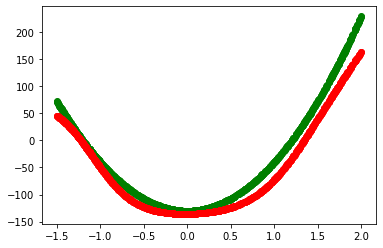

In [6]:
%%time
np.random.seed(2137) # seed ustawiony na sztywno, by zawsze dostawać te same wyniki
rmsprop_mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="0|1", norm=True)
_, rmsprop_err = rmsprop_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, rmsprop=True, batch_size=32)

y_pred = rmsprop_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Z momentem

10.332272968053047
CPU times: user 3.23 s, sys: 0 ns, total: 3.23 s
Wall time: 3.23 s


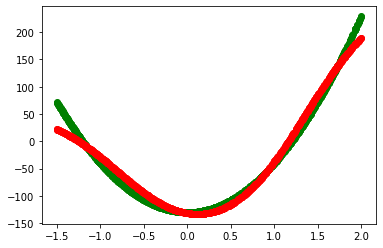

In [7]:
%%time
np.random.seed(2137) # seed ustawiony na sztywno, by zawsze dostawać te same wyniki
momentum_mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="0|1", norm=True)
_, momentum_err = momentum_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, momentum=True, batch_size=32)

y_pred = momentum_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Domyślna

11.465282805723946
CPU times: user 3.16 s, sys: 15.6 ms, total: 3.17 s
Wall time: 3.16 s


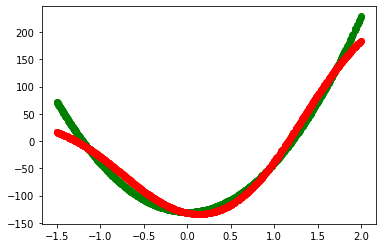

In [8]:
%%time
np.random.seed(2137) # seed ustawiony na sztywno, by zawsze dostawać te same wyniki
normal_mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="0|1", norm=True)
_, normal_err = normal_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = normal_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

(0.0, 2000.0)

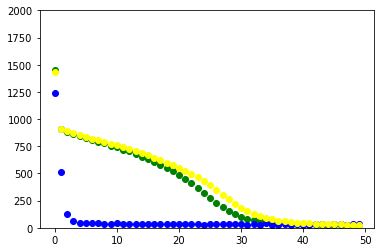

In [9]:
plt.scatter(range(len(momentum_err)), momentum_err, color='green')
plt.scatter(range(len(rmsprop_err)), rmsprop_err, color='blue')
plt.scatter(range(len(normal_err)), normal_err, color='yellow')
plt.ylim(0, 2000)

In [10]:
def get_score(network, df):
    y_pred = network.predict(np.expand_dims(df['x'], 1))
    y_pred = np.squeeze(y_pred)
    return metrics.mean_absolute_error(df['y'], y_pred)

### Wynik na zbiorze testowym
##### normalna

In [11]:
get_score(normal_mlp, test_df)

23.504269571195724

##### RMSProp

In [12]:
get_score(rmsprop_mlp, test_df)

27.662727018943613

##### moment

In [13]:
get_score(momentum_mlp, test_df)

21.732769707227114

# Zbiór steps-large

In [14]:
train_df = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)

##### RMSProp

2.6840254503744743
CPU times: user 1min 9s, sys: 46.9 ms, total: 1min 9s
Wall time: 1min 9s


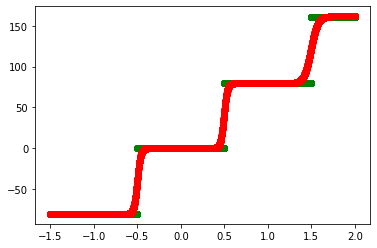

In [15]:
%%time
np.random.seed(2137)
rmsprop_mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False)
_, rmsprop_err = rmsprop_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32, rmsprop=True)

y_pred = rmsprop_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Z momentem

4.007486241334534
CPU times: user 1min 16s, sys: 46.9 ms, total: 1min 16s
Wall time: 1min 16s


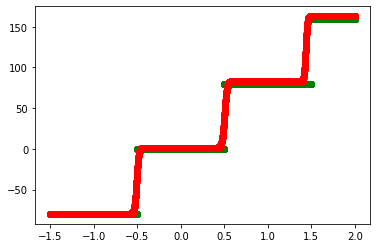

In [16]:
%%time
np.random.seed(2137)
momentum_mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False)
_, momentum_err = momentum_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32, momentum=True)

y_pred = momentum_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Domyślna

3.927003544095477
CPU times: user 1min 17s, sys: 109 ms, total: 1min 17s
Wall time: 1min 17s


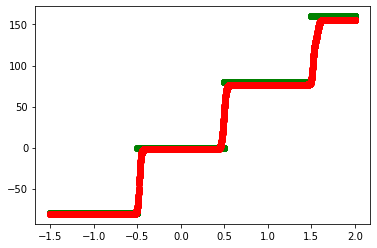

In [17]:
%%time
np.random.seed(2137)
normal_mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False) # wyłączenie domyślnej normalizacji outputu
_, normal_err = normal_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, batch_size=32)

y_pred = normal_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

(0.0, 4000000.0)

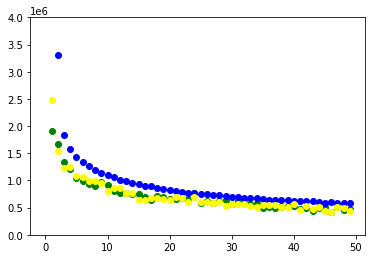

In [18]:
plt.scatter(range(len(momentum_err)), momentum_err, color='green')
plt.scatter(range(len(rmsprop_err)), rmsprop_err, color='blue')
plt.scatter(range(len(normal_err)), normal_err, color='yellow')
plt.ylim(0, 4000000)

### Wynik na zbiorze testowym
##### normalna

In [19]:
get_score(normal_mlp, test_df)

4.081057117776524

##### RMSProp

In [20]:
get_score(rmsprop_mlp, test_df)

2.6620580829547027

##### moment

In [21]:
get_score(momentum_mlp, test_df)

3.731887252107544

# Zbiór multimodal-large

In [22]:
train_df = pd.read_csv('./mio1/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/multimodal-large-test.csv', index_col=0)

##### RMSProp

2.7395068977737846
CPU times: user 43.5 s, sys: 31.2 ms, total: 43.5 s
Wall time: 43.6 s


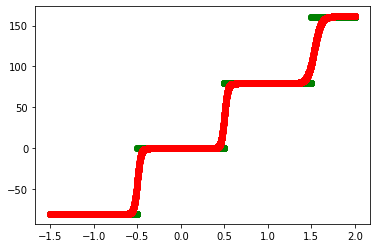

In [23]:
%%time
np.random.seed(1111)
rmsprop_mlp = Network(["sigmoid", "linear"], [1,5,1], gen_type="norm", norm=False) #generowanie z rozkładu normalnego N(0,1)
_, rmsprop_err = rmsprop_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, rmsprop=True, batch_size=32)

y_pred = rmsprop_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Z momentem

2.6242199155250274
CPU times: user 48.5 s, sys: 78.1 ms, total: 48.6 s
Wall time: 48.7 s


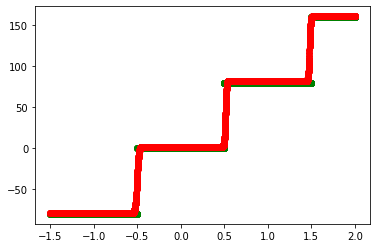

In [24]:
%%time
np.random.seed(1111)
momentum_mlp = Network(["sigmoid", "linear"], [1,5,1], gen_type="norm", norm=False) #generowanie z rozkładu normalnego N(0,1)
_, momentum_err = momentum_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, momentum=True, batch_size=32)

y_pred = momentum_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Domyślna

57.517174553030394
CPU times: user 43.2 s, sys: 31.2 ms, total: 43.3 s
Wall time: 43.3 s


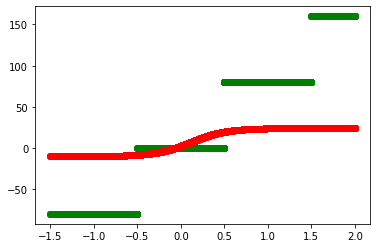

In [25]:
%%time
np.random.seed(1111)
normal_mlp = Network(["sigmoid", "linear"], [1,5,1], gen_type="norm", norm=False) #generowanie z rozkładu normalnego N(0,1)
_, normal_err = normal_mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=50, l_rate=0.1, rmsprop=True)

y_pred = normal_mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
print(metrics.mean_absolute_error(train_df['y'], y_pred))

plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

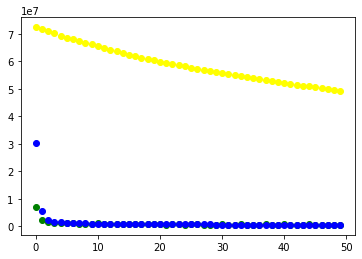

In [26]:
plt.scatter(range(len(momentum_err)), momentum_err, color='green')
plt.scatter(range(len(rmsprop_err)), rmsprop_err, color='blue')
plt.scatter(range(len(normal_err)), normal_err, color='yellow')

(0.0, 2000000.0)

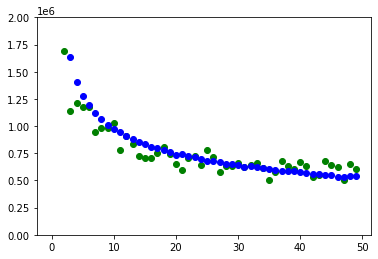

In [27]:
plt.scatter(range(len(momentum_err)), momentum_err, color='green')
plt.scatter(range(len(rmsprop_err)), rmsprop_err, color='blue')
plt.ylim(0,2000000)

### Wynik na zbiorze testowym
##### normalna

In [28]:
get_score(normal_mlp, test_df)

57.16487592807104

##### RMSProp

In [29]:
get_score(rmsprop_mlp, test_df)

2.9262792310506844

##### moment

In [30]:
get_score(momentum_mlp, test_df)

3.1658260690283986

### Uwagi
Wykresy zbieżności są w oparciu o squared error, dlatego starałam się dawać wszystkim 3 sieciom dla danego zbioru taki sam learning rate i batch_size.
# Wnioski
W przypadku square-large przy zadanych parametrach learning rate 0.1 i batch_size 32 sieć zbiegała najszybciej metodą RMSProp, znacznie wolniej z momentem i bez optymalizacji (te 2 metody miały porównywalną prędkość, ale moment trochę szybszy). Przy innych parametrach zaobserwowałam inne zachowania - np. przy wyższym learning rate ~0.5 RMSProp wpadał w minimum lokalne, i z niego nie wychodził, a pozostałe sieci zbiegały szybko do docelowego rozkładu.

Przy steps-large różnice w szybkości zbieżności są mniejsze, tutaj jednak widać, że RMSProp zachowuje się gorzej.

Przy multimodal-large sieć bez żadnej optymalizacji pozostała znacznie w tyle w porównaniu do metody z jakąkolwiek optymalizacją. (Tutaj mała uwaga: wiem, że sieć domyślna wygląda tragicznie, ale przy dobrych parametrach naprawdę zbiega, na lab02 zbiegła :))

Ogólnie najbardziej przypadła mi do gustu metoda z momentem, bo ani razu nie miałam z nią takiego problemu jak np. z RMSProp dla za dużego learning rate, a jednocześnie zbiegała szybciej niż sieć bez optymalizacji.